# What's Cooking Challenge

                    Progetto per l'esame di Programmazione di applicazioni di Data Intensive (2019

### Cichetti Federico, Sponziello Nicolò

Il progetto ha lo scopo di creare un modello in grado di classificare il tipo di cucina di una ricetta in base agli ingredienti forniti.

## Librerie

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC

%matplotlib inline

nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/nicolo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nicolo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/nicolo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Esplorazione dei dati

In [4]:
df = pd.read_json("train.json")
pd.options.display.max_colwidth = 500

In [5]:
df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]"
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam masala, double cream, natural yogurt, bay leaf]"


In [6]:
df.tail()

,cuisine,id,ingredients
39769,irish,29109,"[light brown sugar, granulated sugar, butter, warm water, large eggs, all-purpose flour, whole wheat flour, cooking spray, boiling water, steel-cut oats, dry yeast, salt]"
39770,italian,11462,"[KRAFT Zesty Italian Dressing, purple onion, broccoli florets, rotini, pitted black olives, Kraft Grated Parmesan Cheese, red pepper]"
39771,irish,2238,"[eggs, citrus fruit, raisins, sourdough starter, flour, hot tea, sugar, ground nutmeg, salt, ground cinnamon, milk, butter]"
39772,chinese,41882,"[boneless chicken skinless thigh, minced garlic, steamed white rice, baking powder, corn starch, dark soy sauce, kosher salt, peanuts, flour, scallions, Chinese rice vinegar, vodka, fresh ginger, egg whites, broccoli, toasted sesame seeds, sugar, store bought low sodium chicken stock, baking soda, Shaoxing wine, oil]"
39773,mexican,2362,"[green chile, jalapeno chilies, onions, ground black pepper, salt, chopped cilantro fresh, green bell pepper, garlic, white sugar, roma tomatoes, celery, dried oregano]"


Notiamo che il dataframe include una colonna non necessaria, id, che quindi possiamo rimuovere per liberare spazio in memoria

In [7]:
if "id" in df:
    df.drop("id", inplace=True, axis=1)
df.head()

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]"
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam masala, double cream, natural yogurt, bay leaf]"


Iniziamo con visualizzare i dati
* quante ricette sono presenti
* il totale degli ingredienti

In [8]:
len(df)

39774

Le ricette da classificare nel dataset sono 39774 in totale

In [9]:
len(df['cuisine'].unique())

20

In totale ci sono 20 tipi di cucine differenti in cui è possibile classificare le ricette

In [10]:
df['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

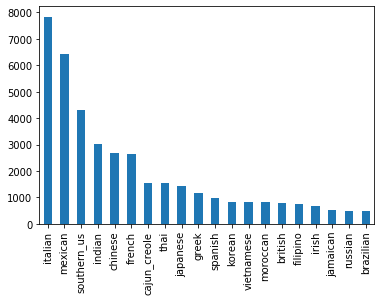

In [11]:
df['cuisine'].value_counts().plot("bar")

Dal grafico possiamo notare che le classi sono sbilanciate
* sono presenti molte ricette della cucina italiana
* mentre ci sono poche ricette Russe e Braziliane

Per analizzare gli ingredienti, per adesso usiamo un approccio iterativo

In [12]:
ingredients = set()
for recipe in df['ingredients']:
    for i in recipe:
        ingredients.add(i)

In [13]:
len(ingredients)

6714

In totale notiamo che ci sono 6714 ingredienti diversi nel dataset

Visualizziamo quelli più usati

In [14]:
ingredients_list = list()
for i in df['ingredients']:
    for word in i:
        ingredients_list.append(word)

In [15]:
common_ingredients = pd.Series(ingredients_list)
common_ingredients.value_counts().nlargest(15)

salt                   18049
olive oil               7972
onions                  7972
water                   7457
garlic                  7380
sugar                   6434
garlic cloves           6237
butter                  4848
ground black pepper     4785
all-purpose flour       4632
pepper                  4438
vegetable oil           4385
eggs                    3388
soy sauce               3296
kosher salt             3113
dtype: int64

Questi sono gli ingredienti più comuni

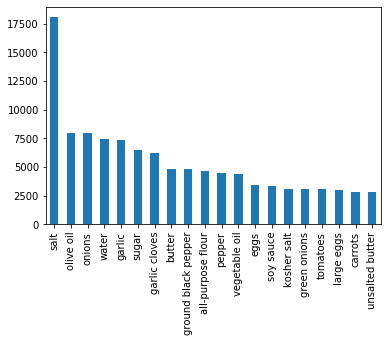

In [18]:
common_ingredients.value_counts().nlargest(20).plot(kind="bar")

Visualizziamo ora gli ingredienti più comuni per cucina

In [196]:
from collections import defaultdict
tmp = df.groupby('cuisine')['ingredients'].apply(list)

def most_common_ingr_by_cuisine(cuisine):
    lists = tmp[cuisine]
    res = defaultdict(int)
    for recipe in lists:
        for ingr in recipe:
            res[ingr] += 1
    return sorted(res.items(), key=lambda x: x[1], reverse=True)

In [199]:
commons = pd.DataFrame(most_common_ingr_by_cuisine('italian')[:10], columns=["ingredient", "count"])
commons

,ingredient,count
0,salt,3454
1,olive oil,3111
2,garlic cloves,1619
3,grated parmesan cheese,1580
4,garlic,1471
5,ground black pepper,1444
6,extra-virgin olive oil,1362
7,onions,1240
8,water,1052
9,butter,1030


In [228]:
pd.DataFrame(most_common_ingr_by_cuisine('brazilian'), columns=["ingredient", "count"]).head(10)

,ingredient,count
0,salt,194
1,onions,133
2,olive oil,118
3,lime,89
4,water,87
5,garlic cloves,83
6,garlic,82
7,cachaca,70
8,sugar,69
9,tomatoes,63


In [229]:
def avg_ingr_per_recipe(cuisine):
    recipes = tmp[cuisine]
    count = 0;
    for recipe in recipes:
        for ingr in recipe:
            count += 1;
    return count/len(recipes)

avg_ingr_per_recipe('brazilian')

9.5203426124197